# Purpose:

2015-02-16 (Monday)

Generate code to import and summarize collection field records in pandas while the real DB is being finished.

# Implementation:

## Imports:

In [1]:
# imports
import csv
import itertools
import os
import re

import pandas as pd
import numpy as np
import datetime as dt

import scipy

import munch


In [2]:
# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)


import ggplot as g


## File paths:

In [3]:
# define paths to files
spring_summer = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/collection_data/2014_spring_summer_from_rob.xlsx"
fall =          "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/collection_data/2014_fall_for_pandas.xlsx"
december = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/collection_data/DEC_2014_survey_for_pandas.xlsx"

h5_out_path = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/collection_data/hdf5/2014_collection_records.h5"
json_out_path = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/collection_data/hdf5/2014_collection_records.json"
pickle_out_path = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/collection_data/hdf5/2014_collection_records.pkl"

In [4]:
village_id_map_path = "/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/names/uganda_village_id_map.csv"

----
# Helper functions

In [5]:
def date_is_between(test_date, start, end):
    
    try:
        return start <= test_date <= end
    except TypeError as exc:
        if "can't compare datetime" in exc.message:
            return False
        else:
            raise

In [6]:
def get_village_id_map(village_id_map_path):
    """
    Generates and returns a `dict` mapping the long-form village names to the letter codes.
    Letter codes map back to themselves to ensure a one way mapping.  
    Enforces both be all UPPERcase to allow case insensitivity as long as
    the map is used like: `map[text.upper()]`.
    :return: `dict`
    """

    village_id_map = {}

    with open(village_id_map_path, 'rb') as csv_file:
        village_ids = csv.reader(csv_file, delimiter=',')
        for pair in village_ids:
            village_id_map[unicode(pair[0].upper())] = unicode(pair[0].upper())
            village_id_map[unicode(pair[1].upper())] = unicode(pair[0].upper())

    return village_id_map

In [7]:
xls = pd.ExcelFile(december)

In [8]:
sheet = xls.parse("dissection data-Kole-Oyam3")

In [9]:
os.path.basename(december)

'DEC_2014_survey_for_pandas.xlsx'

In [10]:
def load_xl_sheets(xl_path):
    dfs = munch.Munch()
    
    xls = pd.ExcelFile(xl_path)
    
    workbook_name = os.path.basename(xl_path)
    
    for sheet in xls.sheet_names:
        if sheet.upper().startswith("DISSECT"):
            worksheet_df = xls.parse(sheetname=sheet, 
                                header=0, 
                                skiprows=None, skip_footer=0, 
                                index_col=None, parse_cols=None, 
                                parse_dates=False, date_parser=None, 
                                na_values=['NA'], 
                                thousands=None, chunksize=None, 
                                convert_float=False, 
                                has_index_names=False, converters=None)
            
            worksheet_df['workbook'] = workbook_name
            worksheet_df['worksheet'] = sheet
            
            dfs[sheet] = worksheet_df 
            
    return dfs

In [11]:
def recode_villages(df):
    map_func = lambda x: village_id_map[x.upper()]
        
    new_codes = df.Village.apply(map_func)
    df.Village = new_codes    

In [12]:
def recode_dead(df):
    def recode_func(x):
        # this is treated as an unknown case
        if pd.isnull(x):
            return x

        x = unicode(x)

        # True means DEAD
        # False means LIVE or NOT-DEAD
        # None means unknown

        try:
            # deal with Live type cases
            if x.upper().startswith('L'):
                return False


            if x.startswith('0'):
                return False


            # deal with Dead type cases
            if x.upper().startswith('D'):
                return True


            if x.startswith('1'):
                return True


            # deal with unknown type cases
            if x.upper().startswith('UN'):
                return None
        except AttributeError:
            return x

        msg = "The value {x} was not expected and this function must be corrected to continue.".format(x=x)
        raise ValueError(msg)

    new_dead = df.Dead.apply(recode_func)
    df.Dead = new_dead

##########################################

def recode_teneral(df):
    def recode_func(x):

        # this is treated as an unknown case
        if pd.isnull(x):
            return x

        x = unicode(x)

        # True means teneral
        # False means NOT-teneral
        # None means unknown

        try:
            # deal with NOT-teneral type cases
            if x.upper().startswith('N'):
                return False

            if x.startswith('0'):
                return False

            # deal with Teneral type cases
            if x.upper().startswith('T'):
                return True
            
            if x.startswith('1'):
                return True


            # Deal with unknown type cases
            if x.upper().startswith('UN'):
                return x
        except AttributeError:
            return x

        msg = "The value {x} was not expected and this function must be corrected to continue.".format(x=x)
        raise ValueError(msg)
    
    
    new_teneral = df.Teneral.apply(recode_func)
    df.Teneral = new_teneral

##########################################

def recode_positives(df):
    def recode_func(x):
        # this is treated as an unknown case
        if pd.isnull(x):
            return x

        y = unicode(x)

        # deal with Unknown type cases
        if y.upper().startswith('UN'):
            return None

        if y.upper().startswith('DEAD'):
            return None


        # deal with Positive type cases
        if y.startswith('1'):
            return True


        if y.upper().startswith('TRUE'):
            return True

        if y.upper().startswith('P'):
            return True

        if y.upper().startswith('Y'):
            return True


        # deal with Negative type cases
        if y.upper().startswith('NO'):
            return False

        if y.upper().startswith('FALSE'):
            return False


        if y.startswith('0'):
            return False


        msg = "The value {x} was not expected and this function must be corrected to continue.".format(x=x)
        raise ValueError(msg)


    new_prob = df.prob.apply(recode_func)
    df.prob = new_prob
    
    new_midgut = df.midgut.apply(recode_func)
    df.midgut = new_midgut
    
    new_sal_gland = df.sal_gland.apply(recode_func)
    df.sal_gland = new_sal_gland

##########################################

def recode_species(df):

    recode_func = lambda x: ''.join(x.split('.')).capitalize()

    new_Species = df.Species.apply(recode_func)
    df.Species = new_Species

##########################################

def recode_sex(df):

    recode_func = lambda x: x.upper()

    new_Sex = df.Sex.apply(recode_func)
    df.Sex = new_Sex
    
##########################################

date_delim = re.compile('[\./-]')

def cast_unicode_as_date(x):
    if not isinstance(x, unicode):
        return x
    
    parts = date_delim.split(x)
    
    if len(parts) != 3:
        return x
    
    if len(parts[0]) != 4:
        return x
    
    return dt.datetime(int(parts[0]), int(parts[1]), int(parts[2]))

def recode_date(df):
    new_date = df.Date.apply(cast_unicode_as_date)
    df.Date = new_date
    

In [13]:
def aggregate_column_from_df_list(df_list, col_name):
    agg_data = []
    for df in df_list:
        agg_data.extend(list(df[col_name]))
        
    
    return agg_data

### Functions that add new columns

In [14]:
def add_infection_state_col(df):
    df['infection_state'] = df[['prob','midgut','sal_gland']].any(skipna=True,axis=1)      

----
# Helpful constants

In [15]:
village_id_map = get_village_id_map(village_id_map_path)

In [16]:
# pdb

In [17]:
spring_summer_dfs = load_xl_sheets(spring_summer)
fall_dfs = load_xl_sheets(fall)
december_dfs = load_xl_sheets(december)

In [18]:
fall_dfs.values()[0].head(2)

,Village,Trap_No,Date,Species,Sex,Teneral,Dead,Fly_Number,Hunger_stage,prob,midgut,sal_gland,Wing_fray,Kept_in,Comment,workbook,worksheet
0,Kitgum town council,1,2014-10-08,Gff,M,T,0,1,NaN,0,0,0,NaN,Ethanol,NaN,2014_fall_for_pandas.xlsx,Dissection data-Kitgum
1,Kitgum town council,1,2014-10-08,Gff,M,NT,0,2,3,0,0,0,2,Ethanol,NaN,2014_fall_for_pandas.xlsx,Dissection data-Kitgum


In [19]:
december_dfs.values()[0].head(3)

,Village,Trap_No,Date,Species,Sex,Teneral,Dead,Fly_Number,Hunger_stage,prob,midgut,sal_gland,Wing_fray,Kept_in,Comment,workbook,worksheet
0,Ocala,11,2014-12-15,Gff,F,NT,NaN,1,2,0,0,0,2,Ethanol,NaN,DEC_2014_survey_for_pandas.xlsx,dissection data-Kole-Oyam3
1,Ocala,11,2014-12-15,Gff,M,NT,NaN,2,2,0,0,0,2,Ethanol,NaN,DEC_2014_survey_for_pandas.xlsx,dissection data-Kole-Oyam3
2,Ocala,10,2014-12-15,Gff,M,NT,NaN,3,2,0,0,0,2,Ethanol,No MG,DEC_2014_survey_for_pandas.xlsx,dissection data-Kole-Oyam3


In [20]:
# pdb

In [21]:
# list all dfs and run our recoder's so far
df_all = spring_summer_dfs.values() + fall_dfs.values() + december_dfs.values()

for df in df_all:
    recode_sex(df)
    recode_species(df)
    recode_villages(df)
    recode_positives(df)
    recode_dead(df)
    recode_teneral(df)
    recode_date(df)
    add_infection_state_col(df)
    

In [22]:
df.head()

,Village,Trap_No,Date,Species,Sex,Teneral,Dead,Fly_Number,Hunger_stage,prob,midgut,sal_gland,Wing_fray,Kept_in,Comment,workbook,worksheet,infection_state
0,OCU,6,2014-12-20,Gff,M,False,False,1,2,False,False,False,3,Ethanol,0,DEC_2014_survey_for_pandas.xlsx,Dissection data Dokolo-kab,False
1,OCU,6,2014-12-20,Gff,M,False,False,2,1,False,False,False,2,Ethanol,0,DEC_2014_survey_for_pandas.xlsx,Dissection data Dokolo-kab,False
2,OCU,6,2014-12-20,Gff,M,False,False,3,1,False,False,False,2,Ethanol,0,DEC_2014_survey_for_pandas.xlsx,Dissection data Dokolo-kab,False
3,OCU,6,2014-12-20,Gff,M,False,False,4,2,False,False,False,2,Ethanol,0,DEC_2014_survey_for_pandas.xlsx,Dissection data Dokolo-kab,False
4,OCU,6,2014-12-20,Gff,M,False,False,5,1,False,False,False,2,Ethanol,0,DEC_2014_survey_for_pandas.xlsx,Dissection data Dokolo-kab,False


In [23]:
df_all[2].head()

,Village,Trap_No,Date,Species,Sex,Teneral,Dead,Fly_Number,Hunger_stage,Wing_fray,prob,midgut,sal_gland,Kept_in,Comment,workbook,worksheet,infection_state
0,GOR,2,2014-07-27,Gff,F,False,False,GOR-14 001,2,2,False,False,False,EtOH,NaN,2014_spring_summer_from_rob.xlsx,Dissection Data-Amuru,False
1,GOR,2,2014-07-27,Gff,F,False,False,GOR-14 002,2,2,False,False,False,EtOH,NaN,2014_spring_summer_from_rob.xlsx,Dissection Data-Amuru,False
2,GOR,2,2014-07-27,Gff,M,False,False,GOR-14 003,3,2,False,False,False,EtOH,NaN,2014_spring_summer_from_rob.xlsx,Dissection Data-Amuru,False
3,GOR,2,2014-07-27,Gff,F,False,False,GOR-14 004,3,2,False,False,False,EtOH,NaN,2014_spring_summer_from_rob.xlsx,Dissection Data-Amuru,False
4,GOR,2,2014-07-27,Gff,F,False,False,GOR-14 005,2,2,False,False,False,EtOH,NaN,2014_spring_summer_from_rob.xlsx,Dissection Data-Amuru,False


In [24]:
(df_all[2].prob | df_all[2].midgut | df_all[2].sal_gland).sum()

0

In [25]:
prob_all = aggregate_column_from_df_list(df_all, 'prob')

prob_all.count(True)

0

In [26]:
midgut_all = aggregate_column_from_df_list(df_all, 'midgut')

midgut_all.count(True)

83

In [27]:
sal_gland_all = aggregate_column_from_df_list(df_all, 'sal_gland')

sal_gland_all.count(True)

3

In [28]:
infection_state_all = aggregate_column_from_df_list(df_all, 'infection_state')

infection_state_all.count(True)

85

---
# Combine dataframes to one for ruling

In [29]:
df_big = pd.concat(df_all)

In [30]:
len(df_big)

6956

In [31]:
df_big.head()

,Comment,Date,Dead,Fly_Number,Hunger_stage,Kept_in,Sex,Species,Teneral,Trap_No,Village,Wing_fray,infection_state,midgut,prob,sal_gland,workbook,worksheet
0,NaN,2014-07-22,False,UWA-14 001,2,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
1,NaN,2014-07-22,False,UWA-14 002,3,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
2,NaN,2014-07-22,False,UWA-14 003,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
3,NaN,2014-07-22,False,UWA-14 004,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
4,NaN,2014-07-22,False,UWA-14 005,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya


---
# Save this table

In [32]:
# df_big.to_hdf(path_or_buf=h5_out_path, key='main', mode='w')

In [33]:
# df_big.to_json(path_or_buf=json_out_path, orient='split', date_format='iso')

In [34]:
df_big.to_pickle(pickle_out_path)

---
# Pivot this table

In [35]:
# df1 = df_big.query('(Species == ["Gff"])').query('Village == ["DUK", "ORB", "ACA", "LIB"]')
df1 = df_big.query('(Species == ["Gff"])').query('Village == ["UWA"]')

In [36]:
df1

,Comment,Date,Dead,Fly_Number,Hunger_stage,Kept_in,Sex,Species,Teneral,Trap_No,Village,Wing_fray,infection_state,midgut,prob,sal_gland,workbook,worksheet
0,NaN,2014-07-22,False,UWA-14 001,2,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
1,NaN,2014-07-22,False,UWA-14 002,3,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
2,NaN,2014-07-22,False,UWA-14 003,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
3,NaN,2014-07-22,False,UWA-14 004,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
4,NaN,2014-07-22,False,UWA-14 005,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
5,NaN,2014-07-22,False,UWA-14 006,2,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
6,NaN,2014-07-22,False,UWA-14 007,3,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
7,NaN,2014-07-22,False,UWA-14 008,3,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
8,NaN,2014-07-22,False,UWA-14 009,3,EtOH,F,Gff,False,1,UWA,3,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
9,NaN,2014-07-22,False,UWA-14 010,2,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya


In [37]:

# table1 = pd.pivot_table(df1,index=['Village', 'Fly_Number', 'Date','Dead'],
#                       values=['Species'],
#                       fill_value=0,
#                       aggfunc=[len])
# table1

In [38]:
# table1.to_csv('/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/collection_data/village_data/UWA_2014.csv')

In [39]:
table2 = pd.pivot_table(df_big.query('Species == ["Gff"]'),index=['Village'],
                      values=['Count'],
                      columns=['infection_state'],
                      fill_value=0,
                      aggfunc=[len])
table2

len      
infection_state False True 
Village                    
ABO                 9     0
ACA              1333    21
AG                 41     0
AIN               173     0
AKA               679     6
AKY                31     0
ALE                44     0
ALI                23     0
AMI                67     1
APU                96     1
ASW                 6     0
ATM                 7     0
BOL               100     1
CE                 11     0
CHU                91     0
DUK               192     2
GAN               120     1
GOR               169     0
JIA                45     0
KIL                26     0
KTC                56     1
LAG                17     0
LEA                24     0
LIB                80     1
MOP                 1     0
MWA               309     0
NGO                72     0
OCA               565    12
OCL                 2     0
OCU               577    22
OD                368    12
OGU                34     0
OKS                74     0
OLE                80     0
OLO                82     0
OLW                 2     0
OMI                15     0
OPU                23     0
ORB               124     0
ORI                 4     0
ORV                31     0
OSG                98     0
PAW                12     0
TEO                 1     0
TUM                41     1
UWA               726     3
WEN               101     0

In [40]:
gff_2014 = df_big.query('Species == ["Gff"]')

In [41]:
#how many villages have we sampled in 2014?
len(gff_2014.Village.unique())

47

In [42]:
# How many total files collected?
len(gff_2014.Fly_Number)

6867

In [43]:
# flies dissected?
sum(gff_2014.Dead == False)

3699

In [44]:
# flies not dissected?
sum(gff_2014.Dead == True)

2347

In [45]:
# Positives?
set(gff_2014.infection_state == True)

{False, True}

In [46]:
# positives per dissected fly
85./3699*100

2.297918356312517

In [47]:
# best villages regarding possitives per dissected
table3 = pd.pivot_table(gff_2014.query("Dead == False"),index=['Village'],
                      values=['Count'],
                      columns=['infection_state'],
                      fill_value=0,
                      aggfunc=[len])
table3.head()

len      
infection_state False True 
Village                    
ABO                 5     0
ACA               524    12
AG                 17     0
AIN               141     0
AKA               377     5

In [48]:
pos_per_live = table3['len',True]/table3['len',False]

In [49]:
pos_per_live.sort(ascending=False)

In [50]:
pos_per_live * 100

Village
OCU        6.321839
OD         6.217617
OCA        3.832753
ACA        2.290076
AMI        2.222222
DUK        1.626016
AKA        1.326260
GAN        1.265823
APU        1.041667
UWA        0.632911
ALI        0.000000
GOR        0.000000
CE         0.000000
ALE        0.000000
AKY        0.000000
AIN        0.000000
AG         0.000000
WEN        0.000000
MOP        0.000000
JIA        0.000000
LEA        0.000000
MWA        0.000000
OGU        0.000000
OKS        0.000000
OLE        0.000000
OLO        0.000000
OLW        0.000000
OPU        0.000000
ORB        0.000000
ORI        0.000000
ORV        0.000000
OSG        0.000000
ABO        0.000000
dtype: float64

In [51]:
# infections by sex
table4 = pd.pivot_table(gff_2014.query("infection_state == True"),index=['Dead'],
                      values=[],
                      columns=['infection_state','Sex'],
                      margins=True,
                      fill_value=0,
                      aggfunc=[len])
table4

len        
infection_state True     All
Sex                F   M    
Dead                        
False             44  26  70
All               57  28  85

In [52]:
table4

len        
infection_state True     All
Sex                F   M    
Dead                        
False             44  26  70
All               57  28  85

In [53]:
gff_2014.head()

,Comment,Date,Dead,Fly_Number,Hunger_stage,Kept_in,Sex,Species,Teneral,Trap_No,Village,Wing_fray,infection_state,midgut,prob,sal_gland,workbook,worksheet
0,NaN,2014-07-22,False,UWA-14 001,2,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
1,NaN,2014-07-22,False,UWA-14 002,3,EtOH,F,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
2,NaN,2014-07-22,False,UWA-14 003,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
3,NaN,2014-07-22,False,UWA-14 004,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya
4,NaN,2014-07-22,False,UWA-14 005,3,EtOH,M,Gff,False,1,UWA,2,False,False,False,False,2014_spring_summer_from_rob.xlsx,Dissection Data-Nwoya


In [54]:
date_mask = gff_2014.Date.apply(lambda x: date_is_between(x,
                                                          dt.datetime(2014, 12, 1, 0, 0),
                                                          dt.datetime(2015, 1, 1, 0, 0)))
dec_dec_gff_2014 = gff_2014[date_mask]

In [55]:
dead_piv = pd.pivot_table(dec_dec_gff_2014, index=['Date',],
                            values=[],
                            columns=['Village','infection_state','Dead'],
                            fill_value=0,
                            margins=1,
                            aggfunc=[len])
dead_piv

len                                                     \
Village               ACA   AKA   AKY        AMI              OCA   OCU        
infection_state     False False False      False       True False False        
Dead                 True  True False True False True False  True False True   
Date                                                                           
2014-12-15 00:00:00    18     0     0    0     0    0     0     1     0    0   
2014-12-16 00:00:00    49    46     0    0     0    0     0    29     0    0   
2014-12-17 00:00:00    91    31     0    0     0    0     0    45     0    0   
2014-12-18 00:00:00    53    14     0    0     0    0     0    27     0    0   
2014-12-20 00:00:00     0     0     8    5     0    0     0     0    69  112   
2014-12-21 00:00:00     0     0     8    4    10    6     1     0   122   67   
2014-12-22 00:00:00     0     0     3    3    15   11     0     0   107   40   
2014-12-23 00:00:00     0     0     0    0    20    5     0     0    50   10   
All                   211    91    19   12    45   22     1   102   348  229   

                                       
Village                      OD   All  
infection_state      True False        
Dead                False  True        
Date                                   
2014-12-15 00:00:00     0     0   140  
2014-12-16 00:00:00     0    16   266  
2014-12-17 00:00:00     0    12   317  
2014-12-18 00:00:00     0     3   200  
2014-12-20 00:00:00     4     0   198  
2014-12-21 00:00:00     3     0   221  
2014-12-22 00:00:00    11     0   190  
2014-12-23 00:00:00     4     0    89  
All                    22    31  1621

In [56]:
# expected positive recoveries from December OCU flies
(22./348)*229

14.477011494252874

In [57]:
# dec_dec_gff_2014.query("Village == 'AMI'")

### Infections by Village/Live/Date

In [58]:
live_gff_2014 = gff_2014.query("Dead == False").query("infection_state == True")
infcd_vil_dead_date = pd.pivot_table(live_gff_2014, index=['Date',],
                            values=[],
                            columns=['Village'],
                            fill_value=0,
                            margins=1,
                            aggfunc=[len])
infcd_vil_dead_date

len                                        
Village             ACA AKA AMI APU DUK GAN OCA OCU  OD UWA All
Date                                                           
2014-03-23 00:00:00   0   2   0   0   0   0   0   0   0   0   2
2014-03-28 00:00:00   0   0   0   1   0   0   0   0   0   0   1
2014-03-29 00:00:00   0   0   0   0   0   0   1   0   0   0   1
2014-05-18 00:00:00   0   0   0   0   0   0   1   0   3   0   4
2014-05-19 00:00:00   0   0   0   0   0   0   1   0   2   0   3
2014-05-21 00:00:00   1   0   0   0   0   0   0   0   1   0   2
2014-05-22 00:00:00   1   0   0   0   0   0   0   0   0   0   1
2014-06-22 00:00:00   0   0   0   0   1   1   0   0   0   0   2
2014-06-25 00:00:00   0   0   0   0   1   0   0   0   0   0   1
2014-07-15 00:00:00   0   0   0   0   0   0   1   0   0   0   1
2014-07-16 00:00:00   0   2   0   0   0   0   2   0   1   0   5
2014-07-17 00:00:00   0   0   0   0   0   0   2   0   1   0   3
2014-07-18 00:00:00   1   1   0   0   0   0   3   0   2   0   7
2014-07-19 00:00:00   4   0   0   0   0   0   0   0   2   0   6
2014-07-20 00:00:00   5   0   0   0   0   0   0   0   0   0   5
2014-07-22 00:00:00   0   0   0   0   0   0   0   0   0   1   1
2014-07-23 00:00:00   0   0   0   0   0   0   0   0   0   2   2
2014-12-20 00:00:00   0   0   0   0   0   0   0   4   0   0   4
2014-12-21 00:00:00   0   0   1   0   0   0   0   3   0   0   4
2014-12-22 00:00:00   0   0   0   0   0   0   0  11   0   0  11
2014-12-23 00:00:00   0   0   0   0   0   0   0   4   0   0   4
All                  12   5   1   1   2   1  11  22  12   3  70

In [59]:
liv_gff_2014 = gff_2014.query("Dead == False").query("infection_state == True").query('Village == ["OCU","OD","OCA","ACA","AMI","DUK","AKA","GAN","APU","UWA"]')
vil_liv_date = pd.pivot_table(liv_gff_2014, index=['Date',],
                            values=[],
                            columns=['Village','infection_state'],
                            fill_value=0,
                            margins=0,
                            aggfunc=[len])
vil_liv_date

len                                             
Village          ACA  AKA  AMI  APU  DUK  GAN  OCA  OCU   OD  UWA
infection_state True True True True True True True True True True
Date                                                             
2014-03-23         0    2    0    0    0    0    0    0    0    0
2014-03-28         0    0    0    1    0    0    0    0    0    0
2014-03-29         0    0    0    0    0    0    1    0    0    0
2014-05-18         0    0    0    0    0    0    1    0    3    0
2014-05-19         0    0    0    0    0    0    1    0    2    0
2014-05-21         1    0    0    0    0    0    0    0    1    0
2014-05-22         1    0    0    0    0    0    0    0    0    0
2014-06-22         0    0    0    0    1    1    0    0    0    0
2014-06-25         0    0    0    0    1    0    0    0    0    0
2014-07-15         0    0    0    0    0    0    1    0    0    0
2014-07-16         0    2    0    0    0    0    2    0    1    0
2014-07-17         0    0    0    0    0    0    2    0    1    0
2014-07-18         1    1    0    0    0    0    3    0    2    0
2014-07-19         4    0    0    0    0    0    0    0    2    0
2014-07-20         5    0    0    0    0    0    0    0    0    0
2014-07-22         0    0    0    0    0    0    0    0    0    1
2014-07-23         0    0    0    0    0    0    0    0    0    2
2014-12-20         0    0    0    0    0    0    0    4    0    0
2014-12-21         0    0    1    0    0    0    0    3    0    0
2014-12-22         0    0    0    0    0    0    0   11    0    0
2014-12-23         0    0    0    0    0    0    0    4    0    0

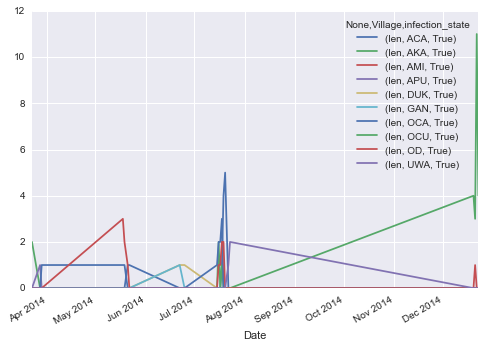

In [60]:
vil_liv_date.plot()

In [61]:
gff_2014.pivot(index='Date', columns='Village', values=None)

ValueError: Index contains duplicate entries, cannot reshape